In [1]:
#Install Dependencies

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# define transformer

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

/home/jtlumpk/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#Model 1

class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(1600, 128)  # Updated size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

shallow_cnn = ShallowCNN()
print(shallow_cnn)

ShallowCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
#Model 2

class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3)
        self.fc1 = nn.Linear(512, 64)  # Updated size to match the flattened output
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

deeper_cnn = DeeperCNN()
print(deeper_cnn)

DeeperCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [5]:
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    #print(f"Epoch {epoch} - Training loss: {running_loss/len(trainloader)}")
    return running_loss / len(trainloader)

In [6]:
def test(model, testloader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy on the test set: {100 * correct / total}%")
    return 100 * correct / total

In [7]:
#Define criterion and Optimizer
shallowModel = ShallowCNN()
deepModel = DeeperCNN()

criterion = nn.CrossEntropyLoss()
shallow_optimizer = torch.optim.Adam(shallowModel.parameters(), lr=0.001)
deep_optimizer = torch.optim.Adam(deepModel.parameters(), lr=0.001)


In [8]:
epochs = 50
shallow_training_losses = []
shallow_test_accuracies = []

deep_training_losses = []
deep_test_accuracies = []

for epoch in range(epochs):
    shallow_train_loss = train(shallowModel, trainloader, criterion, shallow_optimizer)
    shallow_test_accuracy = test(shallowModel, testloader, criterion)

    shallow_training_losses.append(shallow_train_loss)
    shallow_test_accuracies.append(shallow_test_accuracy)
    
for epoch in range(epochs):
    deep_train_loss = train(deepModel, trainloader, criterion, deep_optimizer)
    deep_test_accuracy = test(deepModel, testloader, criterion)

    deep_training_losses.append(deep_train_loss)
    deep_test_accuracies.append(deep_test_accuracy)

/home/jtlumpk/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy on the test set: 98.1%
Accuracy on the test set: 98.76%
Accuracy on the test set: 98.99%
Accuracy on the test set: 99.2%
Accuracy on the test set: 98.91%
Accuracy on the test set: 99.12%
Accuracy on the test set: 99.04%
Accuracy on the test set: 99.13%
Accuracy on the test set: 99.14%
Accuracy on the test set: 99.12%
Accuracy on the test set: 99.03%
Accuracy on the test set: 99.28%
Accuracy on the test set: 99.16%
Accuracy on the test set: 99.13%
Accuracy on the test set: 98.97%
Accuracy on the test set: 99.3%
Accuracy on the test set: 99.0%
Accuracy on the test set: 99.06%
Accuracy on the test set: 99.15%
Accuracy on the test set: 99.18%
Accuracy on the test set: 99.14%
Accuracy on the test set: 99.21%
Accuracy on the test set: 99.14%
Accuracy on the test set: 99.24%
Accuracy on the test set: 99.19%
Accuracy on the test set: 99.29%
Accuracy on the test set: 99.25%
Accuracy on the test set: 99.26%
Accuracy on the test set: 99.14%
Accuracy on the test set: 99.12%
Accuracy on th

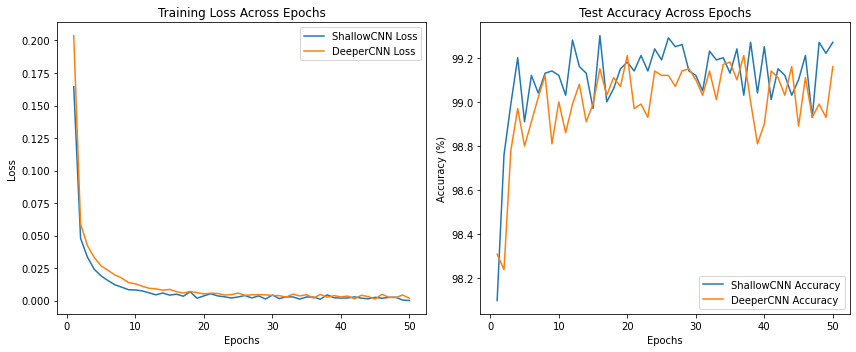

In [9]:
# Plotting the training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), shallow_training_losses, label='ShallowCNN Loss')
plt.plot(range(1, epochs+1), deep_training_losses, label='DeeperCNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs')
plt.legend()

# Plotting the test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), shallow_test_accuracies, label='ShallowCNN Accuracy')
plt.plot(range(1, epochs+1), deep_test_accuracies, label='DeeperCNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Across Epochs')
plt.legend()
plt.tight_layout()
plt.show()
